## Intro

In this post, I describe how Pandas loc (`.loc`) can be used for advanced indexing. We start by reviewing basic indexing and slicing in Pandas. We then dive into `.loc`, and explore how this indexing attribute can be used to select and filter data in your DataFrames. Along the way, I provide simple and complex examples to help you understand how `.loc` works, and discuss common gotchas to watch out for. By the end, you'll have a solid understanding of how to use .loc to access data in Pandas. I will cover Pandas iloc (`.iloc`) in a future article.

This is the third piece in our Professional Pandas series on teaching best practices about writing professional-grade Pandas code. If you have questions or topics that you would like to dive into, please reach out on Twitter to @ponderdata or @\_\_mharrison__, and if you’d like to see the notebook version of this blogpost, you can find it on Github here.

## The Data for Our Examples

For our examples, we will use [Los Angeles crime data](https://catalog.data.gov/dataset/crime-data-from-2020-to-present).

See below for descriptions of the relevant columns, taken directly from the data producer's [data dictionary]("https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8"):

* ``DR_NO`` (Plain Text) - Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits

* ``Date Rptd`` (Date & Time) - MM/DD/YYYY

* ``DATE OCC`` (Date & Time) - MM/DD/YYYY

* ``TIME OCC`` (Plain Text) - In 24 hour military time.

* ``AREA NAME`` (Plain Text) - The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example, 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles.

* ``Crm Cd`` (Plain Text) - Indicates the crime committed. (Same as Crime Code 1)

* ``Crm Cd Desc`` (Plain Text) - Defines the Crime Code provided.

* ``Mocodes`` (Plain Text) -	Modus Operandi: Activities associated with the suspect in commission of the crime. See attached PDF for [list of MO Codes in numerical order](https://data.lacity.org/api/views/2nrs-mtv8/files/4591b6bf-5846-4de0-9fb0-8780a77a036c?download=true&filename=MO_CODES_Numerical_20191119.pdf).

* ``Vict Age`` (Plain Text) - Two character numeric

* ``Vict Sex`` (Plain Text) - F - Female M - Male X - Unknown

* ``Vict Descent`` (Plain Text) - Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian

* ``Premis Cd`` (Number) - The type of structure, vehicle, or location where the crime took place.

* ``Premis Desc`` (Plain Text) - Defines the Premise Code provided.

* ``Weapon Used Cd`` (Plain Text) - The type of weapon used in the crime.

* ``Weapon Desc`` (Plain Text) - Defines the Weapon Used Code provided.

* ``Status`` (Plain Text) - Status of the case. (IC is the default)

* ``Status Desc`` (Plain Text) - Defines the Status Code provided.

* ``Crm Cd 1`` (Plain Text) - Indicates the crime committed. Crime Code 1 is the primary and most serious one. Crime Code 2, 3, and 4 are respectively less serious offenses. Lower crime class numbers are more serious.

* ``LOCATION`` (Plain Text) - Street address of crime incident rounded to the nearest hundred block to maintain anonymity.

* ``Cross Street`` (Plain Text) - Cross Street of rounded Address

* ``LAT`` (Number) - Latitude

* ``LON`` (Number) - Longtitude

Let's load the data.


In [ ]:
import pandas as pd

url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)

## The Basics on Indexing and Slicing with Pandas

Before we dive into `.loc`, it's important to review some basic indexing and slicing in Pandas. In Pandas, a DataFrame is a two-dimensional size-mutable tabular data structure with rows and columns. You can think of it like a spreadsheet or an Excel sheet.


To access a specific column in a DataFrame, you can use square brackets (e.g., ``df[col]``). This is called *index access* and will return a series in Pandas. Let's get the *Crime Description column*.


In [ ]:
df['Crm Cd Desc']


0                                  BATTERY - SIMPLE ASSAULT
1                                  BATTERY - SIMPLE ASSAULT
2                 SEX OFFENDER REGISTRANT OUT OF COMPLIANCE
3                  VANDALISM - MISDEAMEANOR ($399 OR UNDER)
4         VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...
                                ...                        
632385                                    THEFT OF IDENTITY
632386    THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...
632387                                     VEHICLE - STOLEN
632388                                     VEHICLE - STOLEN
632389    THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...
Name: Crm Cd Desc, Length: 632390, dtype: object

Note that we can also access a single column by *attribute* access IF the column has a valid Python attribute name. The column must start with an alphabetic character or underscore and the rest of the name must be alphanumerics or underscores. Because *Crm Cd Desc* has spaces, we will get an error when we try to access it:

In [ ]:
df.Crm Cd Desc

SyntaxError: ignored

However, we can access the *AREA* column this way because the column name is a valid Python attribute name:

In [ ]:
df.AREA

0          3
1          1
2          1
3         15
4         19
          ..
632385     3
632386    10
632387    10
632388    11
632389    16
Name: AREA, Length: 632390, dtype: int64

Note that I generally try to have attribute-friendly column names or update them if they are not. Most code editing environments for Python have better completion on attribute access, and for that reason, I tend to use it.

We can also pull out multiple columns if we pass in a list of column names instead of a scalar. This returns a dataframe.

In [ ]:
df[['DATE OCC', 'AREA', 'Vict Age']]

,DATE OCC,AREA,Vict Age
0,01/08/2020 12:00:00 AM,3,36
1,01/01/2020 12:00:00 AM,1,25
2,02/13/2020 12:00:00 AM,1,0
3,01/01/2020 12:00:00 AM,15,76
4,01/01/2020 12:00:00 AM,19,31
...,...,...,...
632385,08/02/2022 12:00:00 AM,3,34
632386,12/01/2022 12:00:00 AM,10,68
632387,02/09/2022 12:00:00 AM,10,0
632388,02/08/2022 12:00:00 AM,11,0


### What about Selecting Rows with Pandas Loc?

Pulling out a subset of columns is fine, but you might also want a subset of rows. Neither index access nor attribute access will give you that. However, the focus of this article, ``.loc`` (and ``.iloc`` in future articles), allows you to pull out columns and rows.

Here is the key thing to remember about `.loc`. If you remember anything from this article, remember this:
``.loc`` allows you to pull out rows and columns **by label name**.

 What even is ``.loc``? It is a *property*. A property could be a post of its own, but in short, it allows you to call a method without parameters (or parentheses). When you say ``df.loc``, pandas is actually running the ``.loc`` method and returning the result of it (which is a ``_LocIndexer``).

How do I know all of this? Well, I looked at the source code for Pandas. (This is really easy in Jupyter, just type ``df.loc??`` and run the code. Jupyter will pull up the source code when you put ``??`` after your code.)

It being a property is not particularly interesting. Perhaps the more interesting part is the docstring which describes how you can index off of the property.

### What the Loc Documentation Says About Allowed Inputs

> Allowed inputs are:
> 
> - A single label, e.g. ``5`` or ``'a'``, (note that ``5`` is
>   interpreted as a *label* of the index, and **never** as an
>   integer position along the index).
> - A list or array of labels, e.g. ``['a', 'b', 'c']``.
> - A slice object with labels, e.g. ``'a':'f'``.
> 
>   *warning:: Note that contrary to usual python slices, **both** the start and the stop are included*
> 
> - A boolean array of the same length as the axis being sliced,
>   e.g. ``[True, False, True]``.
> - An alignable boolean Series. The index of the key will be aligned before
>   masking.
> - An alignable Index. The Index of the returned selection will be the input.
> - A ``callable`` function with one argument (the calling Series or
>   DataFrame) and that returns valid output for indexing (one of the above)
> 

One more thing to be aware of that the docs don't make clear. (This is also confusing because this is completely different from how indexing normally occurs in Python.) The inputs to the index include both a *row indexer* and an optional *column indexer*. You separate these by a comma. Keep that in mind through the following examples.




## How to Use Pandas Loc with Each Input Type

Now I will walk you through how to use Pandas loc with each of the above input types, and will turn to the crime data as real-world example data. Note that this data has the default index, the `RangeIndex`, which is a monotonic increasing integer value.

### Part 1: Using Pandas Loc to Index with Scalars

In this case, we will select the row with *label* 5. (Note that I highlighted label, because remember, `.loc` indexes by label and *not* by index! Even though in this example the index labels also happen to be the same as the index position.) The integer 5 inside the square brackets is used to select the row with label 5 in the DataFrame.

The syntax for indexing with `.iloc` is `df.loc[row_indexer, column_indexer]`. In this case, row_indexer is the label 5, and column_indexer is not specified, so all columns are selected.

Here is the code:



In [ ]:
df.loc[5]

DR_NO                                   200100501
Date Rptd                  01/02/2020 12:00:00 AM
DATE OCC                   01/01/2020 12:00:00 AM
TIME OCC                                       30
AREA                                            1
AREA NAME                                 Central
Rpt Dist No                                   163
Part 1-2                                        1
Crm Cd                                        121
Crm Cd Desc                        RAPE, FORCIBLE
Mocodes                       0413 1822 1262 1415
Vict Age                                       25
Vict Sex                                        F
Vict Descent                                    H
Premis Cd                                   735.0
Premis Desc       NIGHT CLUB (OPEN EVENINGS ONLY)
Weapon Used Cd                              500.0
Weapon Desc           UNKNOWN WEAPON/OTHER WEAPON
Status                                         IC
Status Desc                           Invest Cont


This might not look like a row. However, because we asked for a single index value, it gave us a row and used a `Series` to represent it.

One thing to be aware of is that if the row with label 5 does not exist in the DataFrame, this code will raise a `KeyError`. In this example, we try to pull out a row with the non-existent label of *Crm Cd 1*.

In [ ]:
df.loc['Crm Cd 1']

KeyError: ignored

In the next example, we will select a single column. In this case, row_indexer is a slice, `:`. It has no start nor end value, so it selects all of the rows. The column_indexer is the label 'Crm Cd 1', which selects the column with that label. Because we passed in a *scalar*, or a single column name and not a list, it returns a Pandas Series object.

Here is the full code:

In [ ]:
df.loc[:, 'Crm Cd 1']

0         624.0
1         624.0
2         845.0
3         745.0
4         740.0
          ...  
632385    354.0
632386    331.0
632387    510.0
632388    510.0
632389    331.0
Name: Crm Cd 1, Length: 632390, dtype: float64

Notice that the *row selector* for the example was a single colon, `:`.  This syntax might seem weird, but it is actually a *slice*. You could rewrite this slice as `0:632389`, indicating to take all of rows.

### Part 2: Using Pandas Loc to Index with Lists

In our next example, the row_indexer is a list of labels `[0,1,2]`, which selects the rows with those labels, and column_indexer is not specified, so all columns are selected.

Here is the full code:

In [ ]:
df.loc[[0,1,2]]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474


In this next example, we will return all of the rows and two columns, *AREA* and *TIME OCC*.

In [ ]:
df.loc[:, ['AREA', 'TIME OCC']]

,AREA,TIME OCC
0,3,2230
1,1,330
2,1,1200
3,15,1730
4,19,415
...,...,...
632385,3,10
632386,10,1800
632387,10,1530
632388,11,2000


Now let's combine using a list of row labels and column labels:

In [ ]:
df.loc[[0,1,2], ['AREA', 'TIME OCC']]

,AREA,TIME OCC
0,3,2230
1,1,330
2,1,1200


### Part 3: Using Pandas Loc to Index with Slices

Now, we will dive more into passing slices into row and column selectors. Again, this example is passing in two slices, one for the row indexer and another for the column indexer,
 separated by the comma.

In this case, the syntax df.loc[0:2, 'TIME OCC':'Part 1-2'] is used to select the rows with labels 0, 1, and 2, and the columns with labels from 'TIME OCC' to 'Part 1-2', **inclusive**, in the DataFrame.

In [ ]:
df.loc[0:2, 'TIME OCC':'Part 1-2']

,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2
0,2230,3,Southwest,377,2
1,330,1,Central,163,2
2,1200,1,Central,155,2


One gotcha to be aware of is that slicing with ``.loc`` is *inclusive*. It includes the stop value. Normal Python doesn't behave this way. If I slice a string with `0:2`, it uses the *half-open interval*, returning values from index 0 up to but not including 2.

In [ ]:
>>> # Normal Python slices w/ "half-open interval"
>>> 'hello'[0:2]. # 0-h 1-e 

'he'

You can also pass in Python lists with boolean values for the index and column selectors. These lists need to be the same size as the index and columns, respectively. In practice, I don't use this option too often, but for completeness I will show it here.

One place where this is useful is if you have a bunch of columns that have the same prefix/suffix/substring. For example, this dataset has a bunch of columns with *Crm* in them. This example pulls out every third row and selects only the columns that have a `'Crm'` in the them.

In [ ]:
df.loc[[True if i%3 == 2 else False for i in range(len(df))],
       [True if 'Crm' in col else False for col in df.columns]]

,Crm Cd,Crm Cd Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4
2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,845.0,NaN,NaN,NaN
5,121,"RAPE, FORCIBLE",121.0,998.0,NaN,NaN
8,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",341.0,998.0,NaN,NaN
11,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,930.0,NaN,NaN,NaN
14,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),442.0,NaN,NaN,NaN
...,...,...,...,...,...,...
632375,510,VEHICLE - STOLEN,510.0,NaN,NaN,NaN
632378,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",341.0,NaN,NaN,NaN
632381,310,BURGLARY,310.0,998.0,NaN,NaN
632384,626,INTIMATE PARTNER - SIMPLE ASSAULT,626.0,NaN,NaN,NaN


I would probably just write the list comprehension for the column selector in the previous example as:

    [col for col in df.columns if 'Crm' in col]


### Part 4: Using Pandas Loc to Index with Boolean Arrays

In this next example, we pass in what the docs call *an alignable boolean Series*. Often this is called a *boolean array* in the real world (which comes from NumPy). In the Pandas context, a boolean array is a series with true/false values with the same index as another dataframe or series.

In this example, row_indexer is a boolean array created by comparing the values in the *AREA NAME* column to the string `'Central'` using the ``==`` operator. Only the rows where the value is True are selected. The column_indexer is not specified, so all columns are selected.

In [ ]:
df['AREA NAME'] == 'Central' # boolean array

0         False
1          True
2          True
3         False
4         False
          ...  
636127    False
636128    False
636129    False
636130    False
636131    False
Name: AREA NAME, Length: 636132, dtype: bool

You can use a boolean array directly in `.loc`. This should return only the rows from the *Central* area.

In [ ]:
df.loc[df['AREA NAME'] == 'Central']

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
5,200100501,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,30,1,Central,163,1,121,"RAPE, FORCIBLE",...,IC,Invest Cont,121.0,998.0,NaN,NaN,700 S BROADWAY,NaN,34.0452,-118.2534
6,200100502,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,1315,1,Central,161,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),...,IC,Invest Cont,442.0,998.0,NaN,NaN,700 S FIGUEROA ST,NaN,34.0483,-118.2631
7,200100504,01/04/2020 12:00:00 AM,01/04/2020 12:00:00 AM,40,1,Central,155,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,998.0,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632334,220123144,10/24/2022 12:00:00 AM,10/20/2022 12:00:00 AM,1930,1,Central,159,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,NaN,NaN,NaN,1500 JESSE ST,NaN,34.0362,-118.2325
632336,220112110,05/10/2022 12:00:00 AM,01/10/2022 12:00:00 AM,1150,1,Central,195,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,100 W 17TH ST,NaN,34.0329,-118.2631
632340,220107479,03/01/2022 12:00:00 AM,02/28/2022 12:00:00 AM,1400,1,Central,129,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,NaN,NaN,NaN,400 N VIGNES ST,NaN,34.0511,-118.2334
632360,220106541,02/13/2022 12:00:00 AM,02/13/2022 12:00:00 AM,1745,1,Central,145,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,100 E 5TH ST,NaN,34.0471,-118.2474


You can see that rows with index label 3 and 4 are missing because those rows didn't have crimes in the *Central* area.

In [ ]:
df.loc[[3,4], ['AREA NAME']]

,AREA NAME
3,N Hollywood
4,Mission


We can also use a boolean array (or alignable boolean Series as the docs call it) for the column selector. It is normal to think of a boolean array for the index selector, a `True` or `False` value for each row with the same index. What is a boolean array for the column selector?

To use a boolean array for a column selector, you need a Series that has the column names in the index and `True` or `False` values.

In this example, we will select columns with more than the median number of unique column entries. 

First, let's calculate the number of unique entries for each column.

In [ ]:
df.nunique()

DR_NO             632390
Date Rptd           1091
DATE OCC            1091
TIME OCC            1439
AREA                  21
AREA NAME             21
Rpt Dist No         1191
Part 1-2               2
Crm Cd               137
Crm Cd Desc          137
Mocodes           219372
Vict Age             101
Vict Sex               4
Vict Descent          19
Premis Cd            309
Premis Desc          306
Weapon Used Cd        79
Weapon Desc           79
Status                 6
Status Desc            6
Crm Cd 1             139
Crm Cd 2             120
Crm Cd 3              35
Crm Cd 4               6
LOCATION           60076
Cross Street        8884
LAT                 5363
LON                 4953
dtype: int64

Then we will calculate the median of these values.

In [ ]:
df.nunique().median()

137.0

The boolean array will be the columns where the number of unique values is greater than 137.

In [ ]:
df.nunique() > 137

DR_NO              True
Date Rptd          True
DATE OCC           True
TIME OCC           True
AREA              False
AREA NAME         False
Rpt Dist No        True
Part 1-2          False
Crm Cd            False
Crm Cd Desc       False
Mocodes            True
Vict Age          False
Vict Sex          False
Vict Descent      False
Premis Cd          True
Premis Desc        True
Weapon Used Cd    False
Weapon Desc       False
Status            False
Status Desc       False
Crm Cd 1           True
Crm Cd 2          False
Crm Cd 3          False
Crm Cd 4          False
LOCATION           True
Cross Street       True
LAT                True
LON                True
dtype: bool

Let's use this boolean array as the column selector. We will use the slice, `:`, as the row selector to return all of the rows.

In [ ]:
df.loc[:, df.nunique() > 137]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,Rpt Dist No,Mocodes,Premis Cd,Premis Desc,Crm Cd 1,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,377,0444 0913,501.0,SINGLE FAMILY DWELLING,624.0,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,163,0416 1822 1414,102.0,SIDEWALK,624.0,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,155,1501,726.0,POLICE FACILITY,845.0,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,1543,0329 1402,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",745.0,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,1998,0329,409.0,BEAUTY SUPPLY STORE,740.0,14400 TITUS ST,NaN,34.2198,-118.4468
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632385,220314584,08/02/2022 12:00:00 AM,08/02/2022 12:00:00 AM,10,334,0100 1822 0922,501.0,SINGLE FAMILY DWELLING,354.0,4300 W 28TH ST,NaN,34.0311,-118.3335
632386,221017286,12/05/2022 12:00:00 AM,12/01/2022 12:00:00 AM,1800,1047,1822 0385,101.0,STREET,331.0,17200 BURBANK BL,NaN,34.1722,-118.5077
632387,221005507,02/10/2022 12:00:00 AM,02/09/2022 12:00:00 AM,1530,1024,NaN,108.0,PARKING LOT,510.0,18800 SHERMAN WY,NaN,34.2011,-118.5426
632388,221105477,02/10/2022 12:00:00 AM,02/08/2022 12:00:00 AM,2000,1171,NaN,101.0,STREET,510.0,4000 FOUNTAIN AV,NaN,34.0958,-118.2787


### Part 5: Using Pandas Loc to Index with Indexes

Let's look at using an *alignable index* for selection. This consists of passing in an Index that has entries that correspond to entries in the dataframe.

In [ ]:
df.loc[pd.Index([0,5,100]),
       pd.Index(['AREA', 'TIME OCC'])]

,AREA,TIME OCC
0,3,2230
5,1,30
100,1,2210


Why would you use this? In the example above it is just more typing that passing in a list to the row and column indexers.

I grepped through a bunch of my Pandas code to look for realistic examples. Let me show two.

This first example comes from creating a dataset for machine learning. It creates the `X` dataset by dropping rows with missing values. To find the corresponding `y` labels, we use the index from `X`. Note the line `.loc[X.index]`.

In [ ]:
url = 'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/possum.csv'

possum = pd.read_csv(url, index_col=[0])
X = (possum
     .dropna()
     .assign(ones=1)
     .loc[:,['ones',
             'hdlngth', 'skullw', 'totlngth', 'taill', 
             'footlgth', 'earconch', 'eye', 'chest', 'belly']]
    )
y = (possum
     .loc[X.index]. # A better example!
     .age
    )

Here's one more example that combines the `.intersection` method of an Index to gather financial data where we had the smallest openings and the largest gains.

In [ ]:
import pandas as pd
url = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=1669852800&period2=1672444800&interval=1d&events=history&includeAdjustedClose=true'
tsla = pd.read_csv(url)
def get_smallest_open_largest_gain(df_):
    smallest = df_.nsmallest(10, 'Open')
    largest = df_.nlargest(10, 'Gain')
    # passing in an index in the line below!
    return df_.loc[smallest.index.intersection(largest.index)]
    
(tsla
 .astype({"Date": 'datetime64[ns]',
          "Open":'float',
          "High":'float',
          "Low":'float',
          "Close":'float',
          "Adj Close":'float',
          "Volume":'float'})
 .assign(Gain=lambda df_:df_.Close - df_.Open)
 .pipe(get_smallest_open_largest_gain)
)

,Date,Open,High,Low,Close,Adj Close,Volume,Gain
18,2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500.0,2.360001
20,2022-12-30,119.949997,124.480003,119.750000,123.180000,123.180000,157304500.0,3.230003
19,2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300.0,1.430001
14,2022-12-21,139.339996,141.259995,135.889999,137.570007,137.570007,145417400.0,-1.769989
10,2022-12-15,153.440002,160.929993,153.279999,157.669998,157.669998,122334500.0,4.229996


### Part 6: Using Pandas Loc with Functions as Indexers

Now comes the fun part and the brain-bending part: Passing in a function for the selectors. These come in very handy when you are chaining operations, and the index has different values (very common with grouping operations) than the original dataframe at the start of the chain.

Here is an example showing passing in a function that just returns a slice to get the labels from 0 through 10. Again, I don't need to use a function here, but I'm showing it to introduce the concept before completely melting brains.

In [ ]:
def first_ten(df):
  return slice(0,10)
  
df.loc[first_ten]  # same as df.loc[0:10]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468
5,200100501,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,30,1,Central,163,1,121,"RAPE, FORCIBLE",...,IC,Invest Cont,121.0,998.0,NaN,NaN,700 S BROADWAY,NaN,34.0452,-118.2534
6,200100502,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,1315,1,Central,161,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),...,IC,Invest Cont,442.0,998.0,NaN,NaN,700 S FIGUEROA ST,NaN,34.0483,-118.2631
7,200100504,01/04/2020 12:00:00 AM,01/04/2020 12:00:00 AM,40,1,Central,155,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,998.0,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
8,200100507,01/04/2020 12:00:00 AM,01/04/2020 12:00:00 AM,200,1,Central,101,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,IC,Invest Cont,341.0,998.0,NaN,NaN,700 BERNARD ST,NaN,34.0677,-118.2398
9,201710201,06/19/2020 12:00:00 AM,05/26/2020 12:00:00 AM,1925,17,Devonshire,1708,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,AO,Adult Other,341.0,NaN,NaN,NaN,11900 BALBOA BL,NaN,34.2864,-118.5021


Unless I'm reusing the function in multiple places in my code, I generally will inline it with an *anonymous function*, a `lambda`.

This is the same code as above but it uses a `lambda`.

In [ ]:
df.loc[lambda ignore_df: slice(0,10)]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468
5,200100501,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,30,1,Central,163,1,121,"RAPE, FORCIBLE",...,IC,Invest Cont,121.0,998.0,NaN,NaN,700 S BROADWAY,NaN,34.0452,-118.2534
6,200100502,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,1315,1,Central,161,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),...,IC,Invest Cont,442.0,998.0,NaN,NaN,700 S FIGUEROA ST,NaN,34.0483,-118.2631
7,200100504,01/04/2020 12:00:00 AM,01/04/2020 12:00:00 AM,40,1,Central,155,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,998.0,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
8,200100507,01/04/2020 12:00:00 AM,01/04/2020 12:00:00 AM,200,1,Central,101,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,IC,Invest Cont,341.0,998.0,NaN,NaN,700 BERNARD ST,NaN,34.0677,-118.2398
9,201710201,06/19/2020 12:00:00 AM,05/26/2020 12:00:00 AM,1925,17,Devonshire,1708,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,AO,Adult Other,341.0,NaN,NaN,NaN,11900 BALBOA BL,NaN,34.2864,-118.5021


Note that we can also pass in a function to the column selector as well. In this case we get an error because the columns are strings, and the function tries to slice with numbers.

In [ ]:
df.loc[:, first_ten]

TypeError: ignored

Here is the obligatory example with a function in the column selector.

In [ ]:
df.loc[:, lambda adf: slice('TIME OCC','Part 1-2')]

,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2
0,2230,3,Southwest,377,2
1,330,1,Central,163,2
2,1200,1,Central,155,2
3,1730,15,N Hollywood,1543,2
4,415,19,Mission,1998,2
...,...,...,...,...,...
632385,10,3,Southwest,334,2
632386,1800,10,West Valley,1047,1
632387,1530,10,West Valley,1024,1
632388,2000,11,Northeast,1171,1


Here is a more realistic example showing using a function in `.loc` in a chain of operations. Assume we want to understand how vehicle crimes occur over monthly periods. We could use some code like this.

This code uses several functions and methods from the Pandas library to clean, organize, and summarize data in a DataFrame. First, the `.astype` method is used to convert the data types of the 'Date Rptd' and 'DATE OCC' columns to 'Datetime64'. Then, the `.groupby` method is used to group the data by the 'DATE OCC' column and the 'AREA NAME' and 'Crm Cd Desc' columns. The `.size` method is then used to count the number of rows in each group, and the `.unstack` method is used to pivot the data so that the 'Crm Cd Desc' values become column labels.

Finally, the `.loc` indexer is used to select only the columns where the label contains the string 'VEHICLE'. We need to use a function to get the column labels because these columns come from the value of the *Crm Cd Desc* column. They were not columns in the original data frame.

The `a_df` parameter for the `lambda` function is the *intermediate state* of the data in the chain. It is the result of the `.unstack` method on the line above it.

I use functions all the time in `.loc` because I'm a big proponent of chaining your Pandas code to make it easier to understand. (See our [article on chaining](https://ponder.io/professional-pandas-the-pandas-assign-method-and-chaining/) for more details on chaining.) 

In [ ]:
(df
 .astype({'Date Rptd': 'Datetime64',
          'DATE OCC': 'Datetime64',
          })
 .groupby([pd.Grouper(key='DATE OCC', freq='M'), 'AREA NAME', 'Crm Cd Desc'])
 .size()
 .unstack()
 .loc[:,
      lambda a_df: [col for col in a_df.columns if 'VEHICLE' in col]]
 )

Crm Cd Desc             BURGLARY FROM VEHICLE  \
DATE OCC   AREA NAME                            
2020-01-31 77th Street                   75.0   
           Central                      144.0   
           Devonshire                    67.0   
           Foothill                      37.0   
           Harbor                        29.0   
...                                       ...   
2020-06-30 Topanga                       55.0   
           Van Nuys                      81.0   
           West LA                       80.0   
           West Valley                   51.0   
           Wilshire                      50.0   

Crm Cd Desc             BURGLARY FROM VEHICLE, ATTEMPTED  \
DATE OCC   AREA NAME                                       
2020-01-31 77th Street                               NaN   
           Central                                   NaN   
           Devonshire                                NaN   
           Foothill                                  NaN   
           Harbor                                    NaN   
...                                                  ...   
2020-06-30 Topanga                                   2.0   
           Van Nuys                                  2.0   
           West LA                                   1.0   
           West Valley                               NaN   
           Wilshire                                  1.0   

Crm Cd Desc             SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT  \
DATE OCC   AREA NAME                                                       
2020-01-31 77th Street                                               9.0   
           Central                                                   NaN   
           Devonshire                                                NaN   
           Foothill                                                  NaN   
           Harbor                                                    NaN   
...                                                                  ...   
2020-06-30 Topanga                                                   NaN   
           Van Nuys                                                  NaN   
           West LA                                                   NaN   
           West Valley                                               NaN   
           Wilshire                                                  NaN   

Crm Cd Desc             THEFT FROM MOTOR VEHICLE - ATTEMPT  \
DATE OCC   AREA NAME                                         
2020-01-31 77th Street                                 3.0   
           Central                                     1.0   
           Devonshire                                  NaN   
           Foothill                                    NaN   
           Harbor                                      NaN   
...                                                    ...   
2020-06-30 Topanga                                     1.0   
           Van Nuys                                    NaN   
           West LA                                     NaN   
           West Valley                                 2.0   
           Wilshire                                    1.0   

Crm Cd Desc             THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)  \
DATE OCC   AREA NAME                                                          
2020-01-31 77th Street                                               17.0     
           Central                                                   16.0     
           Devonshire                                                20.0     
           Foothill                                                  13.0     
           Harbor                                                    19.0     
...                                                                   ...     
2020-06-30 Topanga                                                   25.0     
           Van Nuys                                                  24.0 

## A Practical Example of Pandas Loc

We will wrap up with a visualization of the previous analysis. I will dive into the *Burglary from Vehicle* column and plot that over time for the different *Area Name* values.

In this example, in the latter ``.loc`` I use a `lambda` function to move the *Hollywood* column to the end so that the red line appears on top of the other columns when we plot.

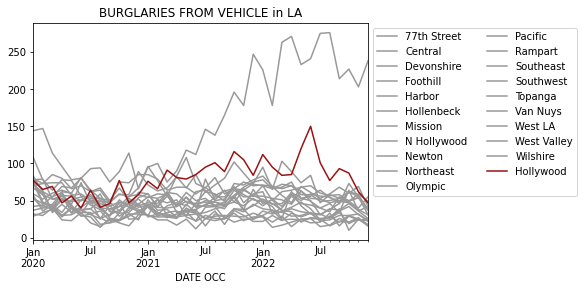

In [ ]:
def set_colors(df):
  global colors
  colors = ['#991111' if col == 'Hollywood' else '#999999' for col in df.columns]
  return df

ax = (df
 .astype({'Date Rptd': 'Datetime64',
          'DATE OCC': 'Datetime64',
          })
 .groupby([pd.Grouper(key='DATE OCC', freq='M'), 'AREA NAME', 'Crm Cd Desc'])
 .size()
 .unstack()
 .loc[:, 'BURGLARY FROM VEHICLE']
 .unstack()
 .loc[:, lambda adf: sorted(adf.columns, key=lambda col:1 if col == 'Hollywood' else -1)]
 .pipe(set_colors)
 .plot(color=colors, title='BURGLARIES FROM VEHICLE in LA')
 )
ax.legend(bbox_to_anchor=(1,1), ncol=2)

## Using `.loc` with Modin

In Modin's pandas API (https://github.com/modin-project/modin), `.loc` works identically to the original pandas. As you can imagine, this is tricky in a distributed dataframe system. There were a lot of new problems to solve:

* What machine is a given row label on?
* How do we know if a row is not on any machine and throw an error for the user?
* How do we make this fast? 

We solved all three of these by separating the dataframe's data from the Index and storing the Index close to the user for fast lookups with `.loc`. We maintain an internal mapping from the fast Index to the machine that the row is on. This way we can make the row lookups fast!

Though `.loc` is fast in Modin, it is not as fast as pandas because of the extra layer between the data and the Index. Still, the lookup should be within a few milliseconds of pandas — and still well within the window of fast interactive performance.

## Conclusion

Thanks for reading part one of our ultimate guide to indexing in Pandas (and the third article in our Professional Pandas series). In this article we introduced using ``.loc`` to select rows and columns. You should have a good understanding of the different inputs that the `.loc` index accepts.

To practice and further improve your skills, try using `.loc` on your own datasets and see how you can effectively index and slice your data. Don't forget to also review the common gotchas discussed in this tutorial to avoid any pitfalls when using these indexing attributes.

Finally, follow [Ponder](https://twitter.com/intent/follow?screen_name=ponderdata) on social media to be alerted when subsequent articles are released and feel free to ask any questions you might have. And if you liked this, check out our previous Professional Pandas posts on [the Pandas assign method / chaining](https://ponder.io/professional-pandas-the-pandas-assign-method-and-chaining/) and [the Pandas merge method](https://ponder.io/professional-pandas-the-pandas-merge-method/).

### About Ponder

Ponder is the company driving Modin and pushing to scale Pandas with you. If you want to seamlessly scale your Pandas code on top of your existing SQL infrastructure, [sign up for a free trial of our product](ponder.io/product)!